# Рекомендательные системы

В этом ноутбуке мы применим алгоритм коллаборативной фильтрации на item-base подходе. Работать мы будем с датасетом MovieLens, который содержит в себе информацию об оценках фильмов пользователями одноименного сайта.

Давайте загрузим необходимые библиотеки.

In [1]:
import pickle as pkl
from collections import defaultdict, Counter
import datetime

from scipy import linalg
import scipy.sparse as sps
import numpy as np
import matplotlib.pyplot as plt

Загрузим предобработанные данные.

In [2]:
with open('data.pkl', 'rb') as f:
    data = pkl.load(f)
users = data['users']
movies = data['movies']
ratings = data['ratings']

### Посмотрим на данные

In [3]:
print('Number of users:', len(users))
print('Number of movies:', len(movies))

Number of users: 6040
Number of movies: 3883


О пользователях нам известен пол (F, M), возраст, закодированная информация о трудоустройстве и zip-code.

In [4]:
users[1001]

{'Age': '50', 'Gender': 'M', 'Occupation': 11, 'Zip-code': '07043'}

Про фильм известны название и список жанров.

In [5]:
movies[1001]

{'Genres': ["Children's", 'Comedy', 'Drama'], 'Title': 'Pollyanna (1960)'}

В словаре ratings хранится список оценок для каждого пользователя.
Каждая оценка - это кортеж из movieId, самой оценки (числа от 1 до 5) и момента времени, когда оценка была сделана.

In [6]:
print('Number of ratings for user 1001:', len(ratings[1001]))
print(ratings[1001][0])

Number of ratings for user 1001: 66
(2918, 4, datetime.datetime(2000, 11, 24, 7, 31, 27))


Посчитаем, сколько всего оценок у нас есть.

In [7]:
print('Number of ratings:', sum(len(user_ratings) for user_ratings in ratings))

Number of ratings: 1000209


Напечатаем, какие фильмы посмотрел пользователь 1001...

In [8]:
print([movies[r[0]]['Title'] for r in ratings[1001]])

['Who Framed Roger Rabbit? (1988)', 'Being John Malkovich (1999)', 'Insider, The (1999)', 'Roger & Me (1989)', 'Dances with Wolves (1990)', 'Contender, The (2000)', 'Back to the Future (1985)', 'Moonstruck (1987)', 'Private Parts (1997)', 'Player, The (1992)', 'Big Night (1996)', 'Boogie Nights (1997)', "She's Gotta Have It (1986)", 'Do the Right Thing (1989)', 'Amistad (1997)', 'Superman (1978)', 'Ed Wood (1994)', 'Outbreak (1995)', 'Pulp Fiction (1994)', 'American Beauty (1999)', 'People vs. Larry Flynt, The (1996)', 'Fargo (1996)', 'Three Kings (1999)', 'Jurassic Park (1993)', 'When Harry Met Sally... (1989)', 'English Patient, The (1996)', 'Thin Blue Line, The (1988)', 'Almost Famous (2000)', 'Jerry Maguire (1996)', 'Cider House Rules, The (1999)', 'Big Chill, The (1983)', 'Good Will Hunting (1997)', 'Wonder Boys (2000)', 'Any Given Sunday (1999)', 'Talented Mr. Ripley, The (1999)', 'Horse Whisperer, The (1998)', 'Jackie Brown (1997)', 'Life and Times of Hank Greenberg, The (1998)'

... и к каким жанрам они относятся.

In [9]:
g1001 = defaultdict(int)
for r in ratings[1001]:
    for genre in movies[r[0]]['Genres']:
        g1001[genre] += 1
g1001

defaultdict(int,
            {'Action': 7,
             'Adventure': 4,
             'Animation': 1,
             'Comedy': 20,
             'Crime': 5,
             'Documentary': 3,
             'Drama': 50,
             'Film-Noir': 1,
             'Musical': 1,
             'Mystery': 2,
             'Romance': 8,
             'Sci-Fi': 3,
             'Thriller': 5,
             'War': 5,
             'Western': 1})

### Валидация

Разобьем данные на тренировочную и тестовую выборку. Разбивать будем рейтинги по времени. Для начала найдем дату, в которую уже было выставлено 80% рейтингов в датасете. И все рейтинги, что были до, попадут в train, а остальные в test.

In [10]:
times = []
for user_ratings in ratings:
    times.extend([x[2] for x in user_ratings])

In [11]:
times = sorted(times)

In [12]:
threshold_time = times[int(0.8 * len(times))]

In [13]:
train = []
test = []
for user_id, user_ratings in enumerate(ratings):
    train.extend((user_id, rating[0], rating[1] / 5.0) for rating in user_ratings if rating[2] <= threshold_time)
    test.extend((user_id, rating[0], rating[1] / 5.0) for rating in user_ratings if rating[2] > threshold_time)
print("ratings in train:", len(train))
print("ratings in test:", len(test))

ratings in train: 800168
ratings in test: 200041


In [14]:
train_by_user = defaultdict(list)
test_by_user = defaultdict(list)
for u, i, r in train:
    train_by_user[u].append((i, r))
for u, i, r in test:
    test_by_user[u].append((i, r))

Научимся считать тестовую метрику (MSE) для предсказаний.

In [15]:
def recom_mse(recom_func):
    mse = 0
    cnt = 0
    for uid in range(len(users)):
        recoms = recom_func(uid)
        tbu = test_by_user[uid]
        test_items = [e[0] for e in tbu]
        test_ratings = np.array([e[1] for e in tbu])        
        errors = np.square(recoms[test_items] - test_ratings)
        mse += sum(errors)
        cnt += len(errors)
    return mse / cnt

Посмотрим характерное значение метрики для случайного предсказания.

In [16]:
def random_recom_func(uid):
    return np.random.rand(len(movies))

In [17]:
recom_mse(random_recom_func)

0.17553213475461302

### Item-based коллаборативная фильтрация

Item-based коллаборативная фильтрация - это почти как user-based, только item :)

В user-based мы считали похожесть пользователей (строк матрицы) и вычисляли оценку пользователя U на фильм I как взвешенное среднее оценок остальных пользователей, где вес - степень похожести на пользователя U.
$$ \hat{r}(u_5, i_1) = \sum_{u \in \{1, 2, 6\}} sim(u_5, u) \cdot r(u, i_1) $$
$$ \sum_{u \in \{1, 2, 6\}} sim(u_5, u) = 1 $$

В item-based мы считаем похожесть фильмов (столбцов матрицы) и вычисляем оценку пользователя U на фильм I как взвешенное среднее оценок пользователя U на остальные фильмы, где вес - степень похожести на фильм I:
$$ \hat{r}(u_5, i_1) = \sum_{i \in \{3, 4, 5\}} sim(i_1, i) \cdot r(u_5, i) $$
$$ \sum_{i \in \{3, 4, 5\}} sim(i_1, i) = 1 $$

<img src="https://hsto.org/files/827/8c7/4dc/8278c74dce8b45e992220121e8a08ae5.png" width="50%"/>

Сейчас мы хотим посчитать похожесть по фильмам.

Для этого нам сначала нужно посчитать средний рейтинг каждого пользователя (потом мы будем центрировать на него оценки этого пользователя).

In [18]:
user_average = defaultdict(list)
# your code here

Построим матрицу user-item.

In [19]:
user_item = np.zeros([len(users), len(movies)])
for u, i, r in train:
    user_item[u, i] = r - user_average[u]

Посчитаем норму каждого фильма (столбца) в этой матрице. Сделаем копию матрицы user-item с нормированными столбцами.

In [20]:
item_norms = # your code here
user_item_normed = user_item / (item_norms[np.newaxis, :] + 1e-6)

Похожестью фильмов будем считать скалярное произведение их нормированных столбцов.

(Без нормирования популярные фильмы были бы наиболее похожи на все остальные фильмы).

In [21]:
item_item_similarity = # your code here

Давайте обнулим те похожести, которые меньше 0. Это означает, что если угол между векторами больше 90 градусов, то мы считаем их совсем не похожими.

In [22]:
# your code here

Напишем функцию, вычисляющую рекомендации для пользователя.

In [23]:
def item_based_recoms(uid):
    user_ratings = train_by_user[uid]
    if len(user_ratings) == 0:
        return np.random.rand(len(movies))
    user_rated_items = [e[0] for e in user_ratings]
    user_rated_ratings = np.array([[e[1]] for e in user_ratings])
    # столбцы в матрице похожести, которые соответствуют оцененным фильмам
    similar_items = item_item_similarity[:, user_rated_items]
    # смешаем пользовательские рейтинги с весами похожести фильмов и таким образом получим предсказанные рейтинги
    recoms = similar_items.dot(user_rated_ratings)[:, 0] / (similar_items.sum(axis=1) + 1e-6)
    return recoms

Посмотрим, какие фильмы рекомендуются пользователю 1001.

In [24]:
recoms1001 = item_based_recoms(1001)
print(recoms1001)

[0.80629559 0.59598739 0.42865171 ... 0.87984804 0.86532725 0.81723548]


In [25]:
top_movies = np.argsort(-recoms1001)
user_1001_rated_items = [e[0] for e in train_by_user[1001]]
top_movies_ids = [i for i in top_movies if i not in user_1001_rated_items][:20]
top_movies_names = [movies[mid]['Title'] for mid in top_movies_ids]
print(top_movies_names)

['Talk of Angels (1998)', 'Time of the Gypsies (Dom za vesanje) (1989)', 'Bittersweet Motel (2000)', 'Beyond Silence (1996)', 'Year of the Horse (1997)', 'Ballad of Narayama, The (Narayama Bushiko) (1958)', 'Midaq Alley (Callejón de los milagros, El) (1995)', 'Silence of the Palace, The (Saimt el Qusur) (1994)', 'Gay Deceivers, The (1969)', 'Detroit 9000 (1973)', 'Modern Affair, A (1995)', '1-900 (1994)', 'Paralyzing Fear: The Story of Polio in America, A (1998)', 'Schlafes Bruder (Brother of Sleep) (1995)', 'Steamboat Willie (1940)', 'Outside Ozona (1998)', 'Broadway Damage (1997)', 'Ulysses (Ulisse) (1954)', 'Naked Man, The (1998)', 'Captives (1994)']


In [26]:
g1001 = defaultdict(int)
for mid in top_movies_ids:
    for genre in movies[mid]['Genres']:
        g1001[genre] += 1
g1001

defaultdict(int,
            {'Action': 1,
             'Adventure': 1,
             'Animation': 1,
             "Children's": 1,
             'Comedy': 3,
             'Crime': 1,
             'Documentary': 3,
             'Drama': 10,
             'Musical': 1,
             'Romance': 2,
             'Thriller': 1})

Видно, что по жанрам предлагаемые фильмы похожи на то, что любит пользователь, хотя информация о жанрах никак не использовалась в модели.

Можем посмотреть на рейтинги в тесте этого пользователя и сравнить с предсказанными.

In [27]:
test_user_rated_items = [e[0] for e in test_by_user[1001]]
test_user_rated_ratings = np.array([[e[1]] for e in test_by_user[1001]])

In [28]:
np.array(recoms1001[test_user_rated_items])

array([0.8618182 , 0.88490002, 0.8234007 , 0.88595563, 0.70044489,
       0.87474672, 0.87713363, 0.8886971 , 0.65266484, 0.87585753,
       0.79001147, 0.86045879, 0.53676937, 0.87375567, 0.84208953,
       0.88465361, 0.84346753, 0.84003731, 0.89812404, 0.89971263,
       0.82395376, 0.8507473 , 0.8690104 , 0.84956161, 0.87531474,
       0.52185757, 0.70771292, 0.83390207, 0.78662905, 0.85312482,
       0.8107856 , 0.85831591, 0.80888691, 0.83363116, 0.86502365,
       0.87067897, 0.89304359, 0.87833356, 0.84292542, 0.88060632,
       0.84581618, 0.86394076, 0.88061128, 0.83182246, 0.88351248,
       0.81123365, 0.84279952, 0.90251491, 0.88472636])

In [29]:
test_user_rated_ratings[:, 0]

array([1. , 1. , 0.8, 0.8, 0.8, 1. , 0.8, 0.8, 0.8, 1. , 0.8, 0.8, 0.6,
       1. , 0.8, 1. , 0.8, 1. , 0.6, 1. , 1. , 0.8, 1. , 0.8, 0.8, 0.4,
       0.4, 0.8, 0.8, 0.8, 1. , 1. , 0.6, 0.8, 0.8, 0.8, 1. , 0.8, 0.8,
       1. , 1. , 1. , 1. , 0.8, 0.6, 0.6, 1. , 0.8, 1. ])

Видно, что какая-то корреляция с правильным ответом есть.

Посчитаем MSE.

In [30]:
recom_mse(item_based_recoms)

0.10657201878837601

Видим, что результат лучше случайного.

## Бонус-треки

### Cold start problem

Есть новые пользователи, которые пока что не поставили ни одной оценки, есть фильмы (новые или просто унылые), которые пока никто не оценил. Нужно думать что с ними делать.

Все пользователи в датасете сделали хотя бы по 20 оценок


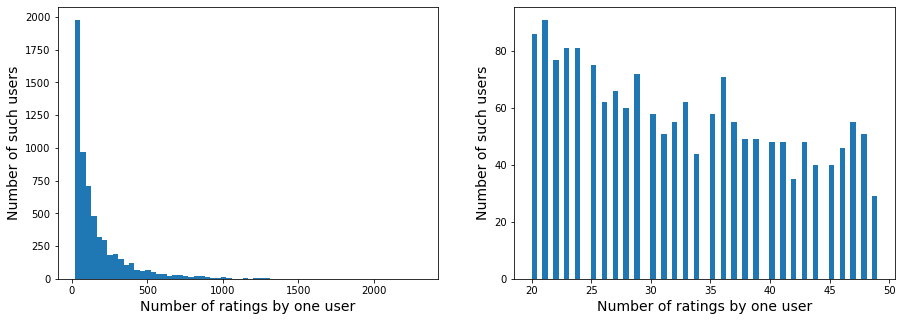

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(axes[0])
plt.hist([len(user_ratings) for user_ratings in ratings], bins=64)
plt.xlabel('Number of ratings by one user', fontsize=14)
plt.ylabel('Number of such users', fontsize=14)

plt.sca(axes[1])
plt.hist([len(user_ratings) for user_ratings in ratings if len(user_ratings) < 50], bins=64)
plt.xlabel('Number of ratings by one user', fontsize=14)
plt.ylabel('Number of such users', fontsize=14)

print('Все пользователи в датасете сделали хотя бы по 20 оценок')

Но на момент времени, разделяющий обучающую и валидационную выборку 600 пользователей не сделали ни одной оценки


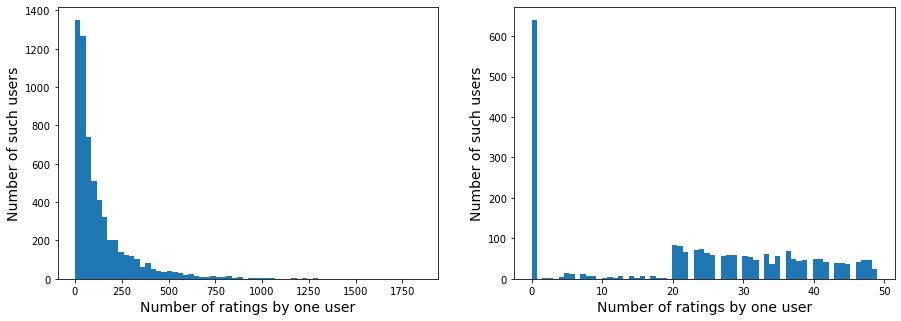

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(axes[0])
plt.hist([len(user_ratings) for user_ratings in train_by_user.values()], bins=64)
plt.xlabel('Number of ratings by one user', fontsize=14)
plt.ylabel('Number of such users', fontsize=14)

plt.sca(axes[1])
plt.hist([len(user_ratings) for user_ratings in train_by_user.values() if len(user_ratings) < 50], bins=64)
plt.xlabel('Number of ratings by one user', fontsize=14)
plt.ylabel('Number of such users', fontsize=14)

print("Но на момент времени, разделяющий обучающую и валидационную выборку "
      "600 пользователей не сделали ни одной оценки")

In [33]:
movie_rates_cnt = {i: 0 for i in range(len(movies))}
for user_ratings in ratings:
    for rating in user_ratings:
        movie_rates_cnt[rating[0]] += 1

175 фильмов не имеют ни одной оценки


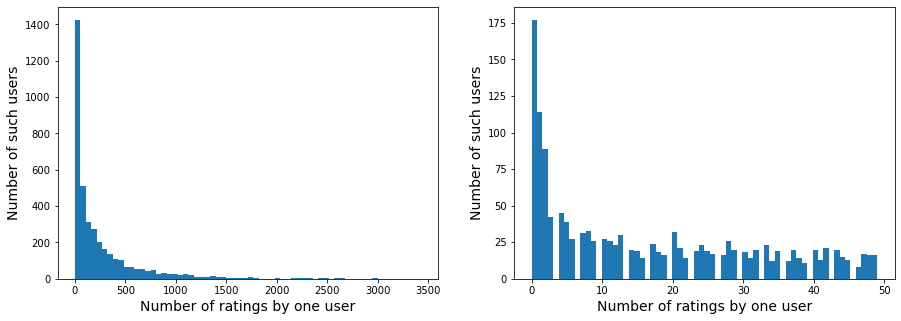

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(axes[0])
plt.hist([i for i in movie_rates_cnt.values()], bins=64)
plt.xlabel('Number of ratings by one user', fontsize=14)
plt.ylabel('Number of such users', fontsize=14)

plt.sca(axes[1])
plt.hist([i for i in movie_rates_cnt.values() if i < 50], bins=64)
plt.xlabel('Number of ratings by one user', fontsize=14)
plt.ylabel('Number of such users', fontsize=14)

print("175 фильмов не имеют ни одной оценки")

In [35]:
print('Это их названия:', [movies[mid]['Title'] for mid in range(len(movies)) if movie_rates_cnt[mid] == 0])

Это их названия: ['Guardian Angel (1994)', 'Headless Body in Topless Bar (1995)', 'Happiness Is in the Field (1995)', 'Gospa (1995)', 'New York Cop (1996)', 'Beyond Bedlam (1993)', 'Desert Winds (1995)', 'Girl in the Cadillac (1995)', 'Homage (1995)', 'Two Crimes (1995)', 'Criminals (1996)', 'Scream of Stone (Schrei aus Stein) (1991)', 'Asfour Stah (1990)', 'Rude (1995)', 'Frisk (1995)', 'Und keiner weint mir nach (1996)', 'Hostile Intentions (1994)', 'They Bite (1996)', "Eye of Vichy, The (Oeil de Vichy, L') (1993)", 'Under the Domin Tree (Etz Hadomim Tafus) (1994)', 'To Cross the Rubicon (1991)', 'Of Love and Shadows (1994)', 'Halfmoon (Paul Bowles - Halbmond) (1995)', 'Two Friends (1986)', 'War Stories (1995)', 'Garcu, Le (1995)', 'Honigmond (1996)', 'Vermont Is For Lovers (1992)', "Someone Else's America (1995)", 'Costa Brava (1946)', 'Quartier Mozart (1992)', 'Touki Bouki (Journey of the Hyena) (1973)', "Pharaoh's Army (1995)", 'Midnight Dancers (Sibak) (1994)', 'Somebody to Love 

Простейшее решение cold start problem: для новых пользователей предлагаем просто самые популярные фильмы (popularity-based approach).

In [36]:
# считаем средний рейтинг каждого фильма
movies_rating = defaultdict(list)
for u, i, r in train:
    movies_rating[i].append(r)
for mid in range(len(movies)):
    movies_rating[mid] = sum(movies_rating[mid]) / (len(movies_rating[mid]) + 1e-6)
movies_rating = np.array([movies_rating[mid] for mid in range(len(movies))])

In [37]:
def item_based_recoms_with_popularity_based_cold_start(uid):
    user_ratings = train_by_user[uid]
    if len(user_ratings) == 0:
        return movies_rating
    user_rated_items = [e[0] for e in user_ratings]
    user_rated_ratings = np.array([[e[1]] for e in user_ratings])
    # столбцы в матрице похожести, которые соответствуют оцененным фильмам
    similar_items = item_item_similarity[:, user_rated_items]
    # смешаем пользовательские рейтинги с весами похожести фильмов и таким образом получим предсказанные рейтинги
    recoms = similar_items.dot(user_rated_ratings)[:, 0] / (similar_items.sum(axis=1) + 1e-6)
    return recoms

In [38]:
recom_mse(item_based_recoms_with_popularity_based_cold_start)

0.03804089438208653

Видим, что даже такой простой трюк значительно улучшает MSE.